<a href="https://colab.research.google.com/github/ee17b031-iittp/Sentiment-Analysis/blob/master/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)
import nltk, re, time
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.datasets import imdb
from nltk import word_tokenize
# !pip install -q tensorflow-datasets

2.3.0


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR6SULH/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR6SULH/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR6SULH/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [5]:
contractions = { 
"ain\\'t": "am not / are not / is not / has not / have not",
"aren\\'t": "are not / am not",
"can\\'t": "cannot",
"can\\'t\\'ve": "cannot have",
"\\'cause": "because",
"could\\'ve": "could have",
"couldn\\'t": "could not",
"couldn\\'t\\'ve": "could not have",
"didn\\'t": "did not",
"doesn\\'t": "does not",
"don\\'t": "do not",
"hadn\\'t": "had not",
"hadn\\'t\\'ve": "had not have",
"hasn\\'t": "has not",
"haven\\'t": "have not",
"he\\'d": "he had / he would",
"he\\'d\\'ve": "he would have",
"he\\'ll": "he shall / he will",
"he\\'ll\\'ve": "he shall have / he will have",
"he\\'s": "he has / he is",
"how\\'d": "how did",
"how\\'d\\'y": "how do you",
"how\\'ll": "how will",
"how\\'s": "how has / how is / how does",
"I\\'d": "I had / I would",
"I\\'d\\'ve": "I would have",
"I\\'ll": "I shall / I will",
"I\\'ll\\'ve": "I shall have / I will have",
"I\\'m": "I am",
"I\\'ve": "I have",
"isn\\'t": "is not",
"it\\'d": "it had / it would",
"it\\'d\\'ve": "it would have",
"it\\'ll": "it shall / it will",
"it\\'ll\\'ve": "it shall have / it will have",
"it\\'s": "it has / it is",
"let\\'s": "let us",
"ma\\'am": "madam",
"mayn\\'t": "may not",
"might\\'ve": "might have",
"mightn\\'t": "might not",
"mightn\\'t\\'ve": "might not have",
"must\\'ve": "must have",
"mustn\\'t": "must not",
"mustn\\'t\\'ve": "must not have",
"needn\\'t": "need not",
"needn\\'t\\'ve": "need not have",
"o\\'clock": "of the clock",
"oughtn\\'t": "ought not",
"oughtn\\'t\\'ve": "ought not have",
"shan\\'t": "shall not",
"sha\\'n\\'t": "shall not",
"shan\\'t\\'ve": "shall not have",
"she\\'d": "she had / she would",
"she\\'d\\'ve": "she would have",
"she\\'ll": "she shall / she will",
"she\\'ll\\'ve": "she shall have / she will have",
"she\\'s": "she has / she is",
"should\\'ve": "should have",
"shouldn\\'t": "should not",
"shouldn\\'t\\'ve": "should not have",
"so\\'ve": "so have",
"so\\'s": "so as / so is",
"that\\'d": "that would / that had",
"that\\'d\\'ve": "that would have",
"that\\'s": "that has / that is",
"there\\'d": "there had / there would",
"there\\'d\\'ve": "there would have",
"there\\'s": "there has / there is",
"they\\'d": "they had / they would",
"they\\'d\\'ve": "they would have",
"they\\'ll": "they shall / they will",
"they\\'ll\\'ve": "they shall have / they will have",
"they\\'re": "they are",
"they\\'ve": "they have",
"to\\'ve": "to have",
"wasn\\'t": "was not",
"we\\'d": "we had / we would",
"we\\'d\\'ve": "we would have",
"we\\'ll": "we will",
"we\\'ll\\'ve": "we will have",
"we\\'re": "we are",
"we\\'ve": "we have",
"weren\\'t": "were not",
"what\\'ll": "what shall / what will",
"what\\'ll\\'ve": "what shall have / what will have",
"what\\'re": "what are",
"what\\'s": "what has / what is",
"what\\'ve": "what have",
"when\\'s": "when has / when is",
"when\\'ve": "when have",
"where\\'d": "where did",
"where\\'s": "where has / where is",
"where\\'ve": "where have",
"who\\'ll": "who shall / who will",
"who\\'ll\'ve": "who shall have / who will have",
"who\\'s": "who has / who is",
"who\\'ve": "who have",
"why\\'s": "why has / why is",
"why\\'ve": "why have",
"will\\'ve": "will have",
"won\\'t": "will not",
"won\\'t\\'ve": "will not have",
"would\\'ve": "would have",
"wouldn\\'t": "would not",
"wouldn\\'t\\'ve": "would not have",
"y\\'all": "you all",
"y\\'all\\'d": "you all would",
"y\\'all\\'d\\'ve": "you all would have",
"y\\'all\\'re": "you all are",
"y\\'all\\'ve": "you all have",
"you\\'d": "you had / you would",
"you\\'d\'ve": "you would have",
"you\\'ll": "you shall / you will",
"you\\'ll\\'ve": "you shall have / you will have",
"you\\'re": "you are",
"you\\'ve": "you have"
}

In [6]:
from bs4 import BeautifulSoup
# function to remove HTML tags
def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

In [7]:
from textblob import TextBlob, Word

In [8]:
def clean_text(text):
  '''Clean the text, with the option to remove stopwords'''
  # Convert words to lower case and split them
  for word in text.split():
    if word.lower().strip() in contractions.keys():
      text = text.replace(word, contractions[word.lower().strip()])
  text = remove_html_tags(text)
  text = text.lower()
  text = word_tokenize(text)
  text= " ". join([word for word in text if word.isalnum() and word != 's'])
  sent = TextBlob(text)
  text = " ". join([w.lemmatize() for w in sent.words])
  return text

In [9]:
training_sentences_clean = []

testing_sentences_clean = []

for s in training_sentences:
  training_sentences_clean.append(clean_text(s))
  
for s in testing_sentences:
  testing_sentences_clean.append(clean_text(s))

In [10]:
vocab_size = 20000
max_length = 120
embedding_dim = 300
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences_clean)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences_clean)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type, padding='post')

testing_sequences = tokenizer.texts_to_sequences(testing_sentences_clean)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, padding='post')


In [11]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2020-09-18 17:41:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-09-18 17:41:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-09-18 17:41:01--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [12]:
path_to_glove_file ="/content/glove.6B.300d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [13]:
word_index = tokenizer.word_index
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 51548 words (13153 misses)


In [14]:
training_padded, validation_padded = padded[:22500], padded[22500:]
training_labels_final, validation_labels_final = training_labels_final[:22500], training_labels_final[22500:]

In [15]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[7]))
print(training_sentences_clean[7])
print(training_sentences[7])

film is based on a genuine 1950s colin <OOV> wrote a set of three london novel absolute beginner city of spade and mr love and justice i have read all three the first two are excellent the last perhaps an experiment that did not come off but work is highly acclaimed and rightly so this musical is the ultimate nightmare to see the fruit of mind being turned into a glitzy soporific apology of a film that say it capture the spirit of 1950s london and doe nothing of the goodness colin <OOV> wa not alive to witness it ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
film is based on a genuine 1950s colin mcinnes wrote a set of three london novel absolute beginner city of spade and mr love and justice i have read all three the first two are excellent the last perhaps an experiment that did not come off but work is highly acclaimed and rightly so this musical is the ultimate nightmare to see the fruit of mind being turned into a glitzy soporific apology of a film that say it capture the spirit of 19

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights = [embedding_matrix],
                            input_length=max_length, trainable =False, name= 'embedding_1'),
    tf.keras.layers.BatchNormalization(name = 'batchnorm_1'),
    tf.keras.layers.LSTM(32, return_sequences=False, name = 'lstm_1', dropout = 0.5),
    tf.keras.layers.BatchNormalization(name = 'batchnorm_2'),
    tf.keras.layers.Dense(1, activation='sigmoid', name = 'dense_1')
], name = "Sentiment-Analysis")
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(0.0001),metrics=['accuracy'])
model.summary()


Model: "Sentiment-Analysis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 300)          19410600  
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 120, 300)          1200      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                42624     
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 19,454,585
Trainable params: 43,321
Non-trainable params: 19,411,264
_________________________________________________________________


In [39]:
num_epochs = 300
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(validation_padded, validation_labels_final), batch_size = 32, callbacks=[tf.keras.callbacks.ModelCheckpoint('/content/bestmodel.hdf5', monitor='val_loss')])

Epoch 1/300
704/704 [==============================] - 7s 10ms/step - loss: 0.8041 - accuracy: 0.5114 - val_loss: 0.7280 - val_accuracy: 0.5164
Epoch 2/300
704/704 [==============================] - 6s 9ms/step - loss: 0.7472 - accuracy: 0.5182 - val_loss: 0.7059 - val_accuracy: 0.5340
Epoch 3/300
704/704 [==============================] - 7s 9ms/step - loss: 0.7221 - accuracy: 0.5311 - val_loss: 0.6965 - val_accuracy: 0.5420
Epoch 4/300
704/704 [==============================] - 7s 10ms/step - loss: 0.7060 - accuracy: 0.5432 - val_loss: 0.6896 - val_accuracy: 0.5516
Epoch 5/300
704/704 [==============================] - 6s 9ms/step - loss: 0.7012 - accuracy: 0.5493 - val_loss: 0.6853 - val_accuracy: 0.5508
Epoch 6/300
704/704 [==============================] - 6s 9ms/step - loss: 0.6923 - accuracy: 0.5558 - val_loss: 0.6815 - val_accuracy: 0.5612
Epoch 7/300
704/704 [==============================] - 6s 9ms/step - loss: 0.6871 - accuracy: 0.5628 - val_loss: 0.6783 - val_accuracy: 0.56

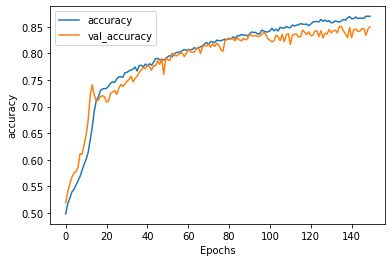

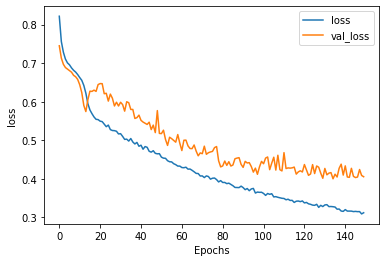

In [37]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [40]:
model.load_weights('bestmodel.hdf5')

In [41]:
model.evaluate(testing_padded, testing_labels_final, verbose = 1)

782/782 [==============================] - 4s 5ms/step - loss: 0.4485 - accuracy: 0.8385


[0.4485192596912384, 0.8385199904441833]